In [2]:
import numpy as np 
import matplotlib.pyplot as plt 
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from GradBasedQHD import GradBasedQHD

from numpy import sin, cos, sqrt, pi, exp

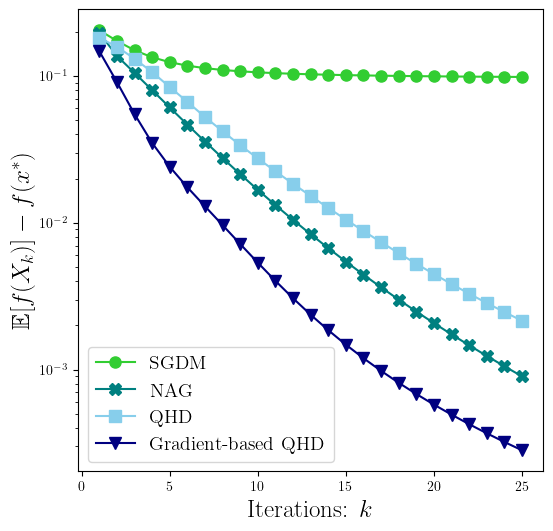

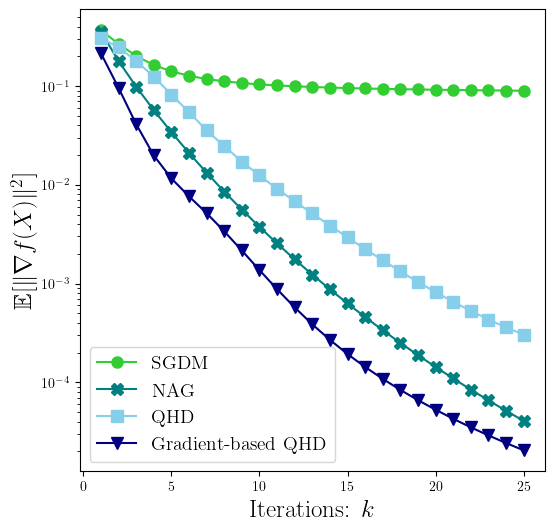

In [3]:
lb = -2
rb = 2
N = 128
success_gap = 1
s = lambda t: 10
beta = lambda t: - 0.1 # 0.01 * np.sqrt(s(t))

def f(X,Y):
    return (X + Y)**4 / 256 + (X-Y)**4 / 128

def du_dx(X,Y):
    return (X + Y)**3 / 64 + (X-Y)**3 / 32

def du_dy(X,Y):
    return (X + Y)**3 / 64 - (X-Y)**3 / 32

grad = [du_dx, du_dy]

model = GradBasedQHD(f, grad, lb, rb, N, success_gap, s, beta, gamma=5)
num_iterations = 25
iter_nums = np.linspace(1, num_iterations, num_iterations)

# run simulation
T = 6
snapshot_times_1, obj_val_1, success_prob_1, wave_fun_1 = model.qhd_simulator(T, 25, 1, return_wave_fun=True, T0=1)
snapshot_times_2, obj_val_2, success_prob_2, wave_fun_2 = model.high_res_qhd_simulator(T, 25, 1, return_wave_fun=True, T0=1)
snapshot_times_3, obj_val_3, success_prob_3, grad_norm_3 = model.sgd_momentum_samples(1000, 25, 2e-1, return_grad_norm=True)
snapshot_times_4, obj_val_4, success_prob_4, grad_norm_4 = model.nesterov_samples(1000, 25, 2e-1, return_grad_norm=True) 

# compute grad norm
grad_norm_1 = []
grad_norm_2 = []
for i in range(len(wave_fun_1)):
    prob_1 = abs(wave_fun_1[i])**2
    prob_2 = abs(wave_fun_2[i])**2
    grad_norm_1.append(np.sum(prob_1 * model.G2))
    grad_norm_2.append(np.sum(prob_2 * model.G2))


# Figure 3: convex optimization
OBJ_DATA = [obj_val_3, obj_val_4, obj_val_1, obj_val_2]
GRAD_NM_DATA = [grad_norm_3, grad_norm_4, grad_norm_1, grad_norm_2]
LABELS = ['SGDM', 'NAG', 'QHD', 'Gradient-based QHD']
COLORS = ['limegreen', 'teal', 'skyblue', 'navy']
MARKERS = ['o', 'X', 's', 'v']

# objective function value 
fig = plt.figure(figsize=(6, 6))
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "DejaVu Serif",
    "text.latex.preamble": r"\usepackage{amsfonts}"
})
cm = sns.cubehelix_palette(start=.5, rot=-.5, reverse=True, as_cmap=True)

for i in range(4):
    plt.plot(iter_nums, OBJ_DATA[i], '-', marker=MARKERS[i], 
             label=LABELS[i], color=COLORS[i], markersize=8)
plt.yscale('log')
plt.xlabel('Iterations: ' + r'$k$', fontsize=18)
plt.ylabel(r'$\mathbb{E}[f(X_k)] - f(x^*)$', fontsize=18)
plt.legend(fontsize=14)
# plt.savefig('convex_plot_a.png', dpi=300, bbox_inches='tight')


# gradient norm minimization
fig = plt.figure(figsize=(6, 6))
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "DejaVu Serif",
    "text.latex.preamble": r"\usepackage{amsfonts}"
})
cm = sns.cubehelix_palette(start=.5, rot=-.5, reverse=True, as_cmap=True)
for i in range(4):
    plt.plot(iter_nums, GRAD_NM_DATA[i], '-', marker=MARKERS[i],
             label=LABELS[i], color=COLORS[i], markersize=8)
plt.yscale('log')
plt.xlabel('Iterations: ' + r'$k$', fontsize=18)
plt.ylabel(r'$\mathbb{E}[\|\nabla f(X)\|^2]$', fontsize=18)
plt.legend(fontsize=14)
# plt.savefig('convex_plot_b.png', dpi=300, bbox_inches='tight')

In [32]:
# run simulation
ITER_NUMS = [10, 25, 50, 100]
STEPSIZES = [0.5, 0.2, 0.1, 0.05]
T = 6

OBJ_DATA = []
GRAD_NM_DATA = []
X_DATA = []

for i in range(len(ITER_NUMS)):
    iter_num = ITER_NUMS[i]
    snapshot_time, obj_val, success_prob, wave_fun = model.high_res_qhd_simulator(T, iter_num, 1, return_wave_fun=True, T0=1)
    grad_norm_temp = [np.sum(np.abs(wave_fun[j])**2 * model.G2) for j in range(len(wave_fun))]

    OBJ_DATA.append(obj_val)
    GRAD_NM_DATA.append(grad_norm_temp)
    X_DATA.append(np.linspace(5/iter_num, 5, iter_num))

In [33]:
GRAD_NM_DATA[0]

[np.float64(0.043065897282844254),
 np.float64(0.010661269245376723),
 np.float64(0.004130858628854118),
 np.float64(0.0013907180797897594),
 np.float64(0.0004960098515611709),
 np.float64(0.00021042818974190564),
 np.float64(0.00010177021368974474),
 np.float64(5.548757513603773e-05),
 np.float64(3.3326307267942236e-05),
 np.float64(2.2072016339062815e-05)]

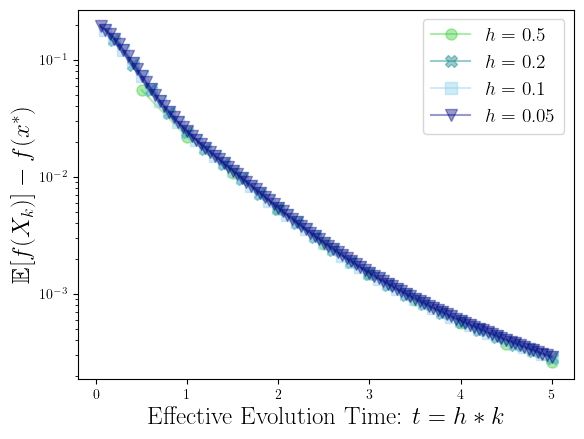

In [36]:
for i in range(len(ITER_NUMS)):
    iter_num = ITER_NUMS[i]
    plt.plot(X_DATA[i], OBJ_DATA[i], '-', marker=MARKERS[i], 
             label=r'$h=$'+ f' {STEPSIZES[i]}', color=COLORS[i], markersize=8,
             alpha=0.4)
plt.yscale('log')
plt.xlabel('Effective Evolution Time: ' + r'$t = h * k$', fontsize=18)
plt.ylabel(r'$\mathbb{E}[f(X_k)] - f(x^*)$', fontsize=18)
plt.legend(fontsize=14)
plt.savefig('grad_qhd_stepsize_a.png', dpi=300, bbox_inches='tight')

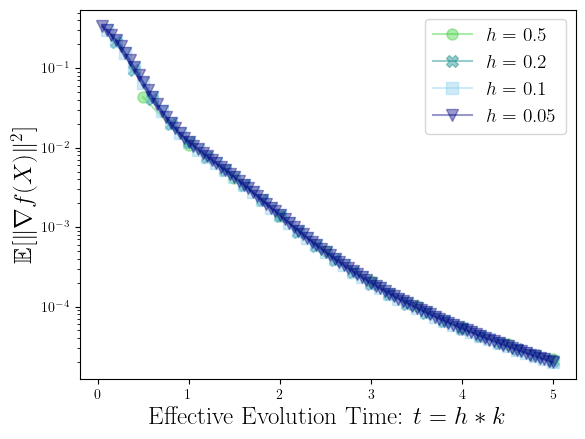

In [37]:
for i in range(len(ITER_NUMS)):
    iter_num = ITER_NUMS[i]
    plt.plot(X_DATA[i], GRAD_NM_DATA[i], '-', marker=MARKERS[i], 
             label=r'$h=$'+ f' {STEPSIZES[i]}', color=COLORS[i], markersize=8,
             alpha=0.4)
plt.yscale('log')
plt.xlabel('Effective Evolution Time: ' + r'$t = h * k$', fontsize=18)
plt.ylabel(r'$\mathbb{E}[\|\nabla f(X)\|^2]$', fontsize=18)
plt.legend(fontsize=14)
plt.savefig('grad_qhd_stepsize_b.png', dpi=300, bbox_inches='tight')